In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [2]:
df_dict = {}  #Dictionary for storing dataframes for m_dot


#CGS UNITS
eta = 0.1   #Efficiency factor for Eddington Mass
c = 3E10     #Speed of Light in cm/s
Msol = 1.989E33 #Mass of sun in g
Myr = 31557600 * 1E6 #1 Myr in Seconds
yr = 31557600 #1 yr in Seconds


a_bh = 0.998 #Black hole max spin
a_ns = 0.001 #NS average spin

G_SI = 6.67408E-11 #N.(m^2)/(kg)^2 
G = 6.674E-8 #(cm)^3 g^-1 s^-2
pi = np.pi

In [7]:
os.chdir('data_mdot')
files = glob.glob('*.dat')

In [8]:
for filename in files:
    print(filename)
    df_dict[filename] = pd.read_csv(filename, delim_whitespace=True,
           header=None, names=['mdot', 'm', 'idum', 'iidd'])

    cut_string = filename.split(sep='_', maxsplit=4)
    df_dict[filename]['Z'] = float(cut_string[1])
    df_dict[filename]['tage'] = float(cut_string[3][:-4])

Z_0.002_tage_50.dat
Z_0.002_tage_5000.dat
Z_0.0002_tage_20.dat
Z_0.02_tage_10.dat
Z_0.02_tage_2000.dat
Z_0.0002_tage_50.dat
Z_0.02_tage_50.dat
Z_0.002_tage_100.dat
Z_0.0002_tage_5000.dat
Z_0.02_tage_20.dat
Z_0.0002_tage_100.dat
Z_0.002_tage_500.dat
Z_0.0002_tage_2000.dat
Z_0.02_tage_5000.dat
Z_0.02_tage_1000.dat
Z_0.02_tage_10000.dat
Z_0.002_tage_2000.dat
Z_0.0002_tage_1000.dat
Z_0.02_tage_200.dat
Z_0.002_tage_200.dat
Z_0.002_tage_1000.dat
Z_0.0002_tage_200.dat
Z_0.002_tage_20.dat
Z_0.0002_tage_10000.dat
Z_0.0002_tage_500.dat
Z_0.0002_tage_10.dat
Z_0.002_tage_10000.dat
Z_0.02_tage_100.dat
Z_0.002_tage_10.dat
Z_0.02_tage_500.dat


In [10]:

df_master = pd.concat(df_dict, ignore_index=True)
m = df_master['m']
mdot = df_master['mdot']

df_master['mdot_gs'] = mdot * (Msol/Myr)   #Mass accretion rate in g/s
mdot_gs = df_master['mdot_gs']

df_master['LEdd'] = 1.2E38 * m #ERG/S
LEdd = df_master['LEdd']
df_master['MEdd'] = np.where(m <= 2.5, LEdd / (0.2 * c**2), LEdd / (1/12 * c**2))
#Ledd = eta * M_dot_eddington * c^2 where eta = 0.2 for NS and 1/12 for bh
MEdd = df_master['MEdd']    
df_master['mdot_ratio'] = mdot_gs / MEdd #AKA Eddington Ratio
mdot_ratio = df_master['mdot_ratio']

df_master['XLsph'] = abs(2.2E39 * (m/10) * (mdot_ratio/10)**2 * (1 + np.log(mdot_ratio)))
df_master['XLsph2'] = 2.2E39 * (m/10) * (mdot_ratio/10)**2
df_master['LXtot'] = np.where(mdot_ratio > 1, LEdd * (1 + np.log(mdot_ratio)), LEdd * mdot_ratio)
#df_master['LXtot'] = LEdd * (1 + np.log(mdot_ratio))


df_master['b'] = np.where(mdot_ratio >= 8.5, 73/mdot_ratio**2, 1)
df_master['b'] = np.where(mdot_ratio >= 150, 3.2E-3, df_master['b'])

df_master['Lx'] = df_master['LXtot']/df_master['b']

df_master['ratio'] = df_master['LXtot'] / df_master['LEdd']
df_master['ratio_beamed'] = df_master['Lx'] / df_master['LEdd']

df_master['theta'] = 2 * np.arccos(1-df_master['b']) #full opening angle in rad
df_master['theta_deg'] = df_master['theta'] * 180/np.pi #deg
df_master['theta_half_deg'] = df_master['theta_deg'] / 2 #Half opening angle

df_master['schw_r'] = 2 * G * m * Msol / c**2   #Schwarzschild radius (cm)
df_master['r_isco_nospin'] = (6 * G * m * Msol) / c**2 #ISCO (nospin) (cm)

df_master['zeta'] = np.tan((pi/2) - np.arccos(1 - (73/(df_master['mdot_ratio']**2))))
df_master['r_isco'] = np.where(m < 2.5, 6, 1.25)    #Units of R_g (i think)
e_wind = 0.25 #Normally between 0.25 to 0.95 (check latex)
beta = 1.4 #Velocity of the wind, distinct from the beta used in ulxlc
df_master['r_sph'] = df_master['r_isco'] * df_master['mdot_ratio']
df_master['r_out'] = 3 * e_wind / (beta * df_master['zeta']) * df_master['mdot_ratio']**3/2 * df_master['r_isco']
df_master['P_wind'] = np.where(m < 2.5,
         G * m * Msol * pi / (3 * c**3 * a_ns) * df_master['r_out']**3 * ((1 - (df_master['r_isco']/df_master['r_out']))**3)/(np.log(df_master['r_out']/df_master['r_isco'])),
         G * m * Msol * pi / (3 * c**3 * a_bh) * df_master['r_out']**3 * ((1 - (df_master['r_isco']/df_master['r_out']))**3)/(np.log(df_master['r_out']/df_master['r_isco'])))
df_master['f_wind'] = 1 / df_master['P_wind']


/home/nk7g14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
/home/nk7g14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in arccos
/home/nk7g14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log
/home/nk7g14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log


In [18]:
plt.style.available

['seaborn-paper',
 'seaborn-pastel',
 'seaborn-colorblind',
 'seaborn-poster',
 'Solarize_Light2',
 'seaborn-white',
 'seaborn-dark-palette',
 'bmh',
 '_classic_test',
 'seaborn-darkgrid',
 'seaborn',
 'seaborn-bright',
 'ggplot',
 'seaborn-talk',
 'seaborn-notebook',
 'seaborn-dark',
 'seaborn-whitegrid',
 'tableau-colorblind10',
 'seaborn-muted',
 'dark_background',
 'grayscale',
 'classic',
 'fivethirtyeight',
 'seaborn-ticks',
 'seaborn-deep',
 'fast']

In [23]:
plt.style.use('seaborn-bright')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ee565df28>,
      dtype=object)

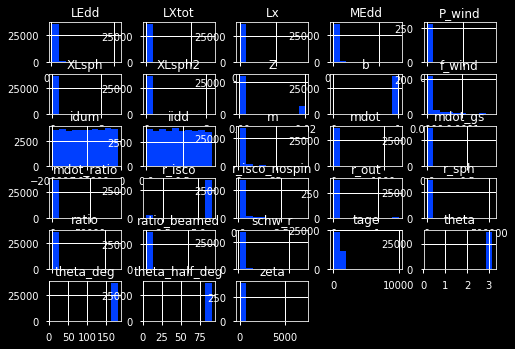

In [24]:
df_master.hist()